Based on Kaggle python3 docker image.
For more explaintation:
https://www.kaggle.com/junxiangji/lstm-sentiment-analysis-keras/edit 


In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from sklearn.feature_extraction.text import CountVectorizer
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
import re

/opt/conda/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
data1 = pd.read_csv('./data/Sentiment.csv')
# Keeping only the neccessary columns
data = data1[['text','sentiment']]

In [3]:
%matplotlib inline
from IPython.display import display, HTML
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
data[0:9]
# data.dtypes

# data[data.sentiment.isnull()]

,text,sentiment
0,RT @NancyLeeGrahn: How did everyone feel about...,Neutral
1,RT @ScottWalker: Didn't catch the full #GOPdeb...,Positive
2,RT @TJMShow: No mention of Tamir Rice and the ...,Neutral
3,RT @RobGeorge: That Carly Fiorina is trending ...,Positive
4,RT @DanScavino: #GOPDebate w/ @realDonaldTrump...,Positive
5,"RT @GregAbbott_TX: @TedCruz: ""On my first day ...",Positive
6,RT @warriorwoman91: I liked her and was happy ...,Negative
7,Going on #MSNBC Live with @ThomasARoberts arou...,Neutral
8,Deer in the headlights RT @lizzwinstead: Ben C...,Negative


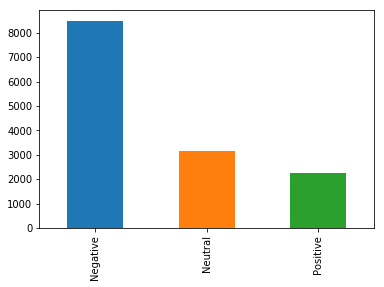

In [4]:
data.sentiment.value_counts().plot(kind="bar")

In [5]:
data = data[data.sentiment != "Neutral"]
data['text'] = data['text'].apply(lambda x: x.lower())
data['text'] = data['text'].apply((lambda x: re.sub('[^a-zA-z0-9\s]','',x)))

print(data[ data['sentiment'] == 'Positive'].size)
print(data[ data['sentiment'] == 'Negative'].size)

# Why size and shape are not same?
print(data.size)
print(data.shape)
#print(data.tail)
for idx,row in data.iterrows():
    row[0] = row[0].replace('rt',' ')
    
max_fatures = 2000
tokenizer = Tokenizer(num_words=max_fatures, split=' ')
tokenizer.fit_on_texts(data['text'].values)

X = tokenizer.texts_to_sequences(data['text'].values)
#tokenizer.word_counts
tokenizer.word_index # index started from 1 not 0.
X[0:2] # type is list


4472
16986
21458
(10729, 2)


{'the': 1,
 'gopdebate': 2,
 'gopdebates': 3,
 'to': 4,
 'is': 5,
 'of': 6,
 'a': 7,
 'and': 8,
 'i': 9,
 'rwsurfergirl': 10,
 'you': 11,
 'in': 12,
 'it': 13,
 'for': 14,
 'trump': 15,
 'that': 16,
 'on': 17,
 'fox': 18,
 'not': 19,
 'this': 20,
 'was': 21,
 'about': 22,
 'realdonaldtrump': 23,
 'amp': 24,
 'news': 25,
 'debate': 26,
 'from': 27,
 'have': 28,
 'at': 29,
 'we': 30,
 'me': 31,
 'he': 32,
 'but': 33,
 'be': 34,
 'candidates': 35,
 'just': 36,
 'are': 37,
 'like': 38,
 'last': 39,
 'they': 40,
 'so': 41,
 'gop': 42,
 'dont': 43,
 'megynkelly': 44,
 'with': 45,
 'all': 46,
 'up': 47,
 'what': 48,
 'people': 49,
 'jeb': 50,
 'foxnews': 51,
 'who': 52,
 'my': 53,
 'how': 54,
 'as': 55,
 'if': 56,
 'bush': 57,
 'night': 58,
 'has': 59,
 'no': 60,
 'their': 61,
 'by': 62,
 'when': 63,
 'can': 64,
 'do': 65,
 'one': 66,
 'more': 67,
 'im': 68,
 'out': 69,
 'or': 70,
 'his': 71,
 'would': 72,
 'chris': 73,
 'him': 74,
 'get': 75,
 'think': 76,
 'republican': 77,
 'donald': 78,
 

[[363,
  122,
  1,
  703,
  2,
  39,
  58,
  237,
  37,
  210,
  6,
  174,
  1761,
  12,
  1324,
  1409,
  743],
 [16, 284, 252, 5, 821, 102, 167, 26, 136, 6, 1, 173, 12, 2, 233, 724, 17]]

In [6]:
 # type is array and we prefixed with zeros. This should be masked in model
X = pad_sequences(X)

print(X.shape)
X[0:2]

(10729, 28)


array([[   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
         363,  122,    1,  703,    2,   39,   58,  237,   37,  210,    6,
         174, 1761,   12, 1324, 1409,  743],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          16,  284,  252,    5,  821,  102,  167,   26,  136,    6,    1,
         173,   12,    2,  233,  724,   17]], dtype=int32)

JIM: can remove **stop words**

For the following Embeding layer. The input is the sequence of words, and the out put will has one more dimation.
Which is because now one words previously a number now become a vector (word embeding)

Ref
https://stackoverflow.com/questions/46155868/keras-embedding-layer

https://keras.io/layers/embeddings/

https://blog.keras.io/using-pre-trained-word-embeddings-in-a-keras-model.html

In [8]:
embed_dim = 128
lstm_out = 196

model = Sequential()

# TODO: consider using mask_zero=True

model.add(Embedding(max_fatures, embed_dim,mask_zero="Ture", input_length = X.shape[1]))
model.add(SpatialDropout1D(0.4))
model.add(LSTM(lstm_out, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(2,activation='softmax'))
model.compile(loss = 'categorical_crossentropy', optimizer='adam',metrics = ['accuracy'])
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 28, 128)           256000    
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 28, 128)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 196)               254800    
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 394       
Total params: 511,194
Trainable params: 511,194
Non-trainable params: 0
_________________________________________________________________
None


In [9]:
# We might add "nutral" sentiment here.
Y = pd.get_dummies(data['sentiment']).values
Y

array([[0, 1],
       [0, 1],
       [0, 1],
       ...,
       [0, 1],
       [1, 0],
       [0, 1]], dtype=uint8)

In [10]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.33, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(7188, 28) (7188, 2)
(3541, 28) (3541, 2)


# Train

In [11]:
batch_size = 32
model.fit(X_train, Y_train, epochs = 10, batch_size=batch_size, verbose = 2)

Epoch 1/10
 - 19s - loss: 0.4253 - acc: 0.8208
Epoch 2/10
 - 19s - loss: 0.3123 - acc: 0.8710
Epoch 3/10
 - 17s - loss: 0.2761 - acc: 0.8887
Epoch 4/10
 - 17s - loss: 0.2463 - acc: 0.9011
Epoch 5/10
 - 17s - loss: 0.2194 - acc: 0.9147
Epoch 6/10
 - 17s - loss: 0.1991 - acc: 0.9228
Epoch 7/10
 - 17s - loss: 0.1845 - acc: 0.9289
Epoch 8/10
 - 21s - loss: 0.1668 - acc: 0.9346
Epoch 9/10
 - 21s - loss: 0.1535 - acc: 0.9395
Epoch 10/10
 - 20s - loss: 0.1397 - acc: 0.9423


In [120]:
model.save('whole_model_20_round.h5')

In [12]:
from keras.models import load_model
model = load_model('whole_model_20_round.h5')

# Validation

In [14]:
validation_size = 1500

X_validate = X_test[-validation_size:]
print(X_validate.shape)
Y_validate = Y_test[-validation_size:]
print(Y_validate.shape)
X_test = X_test[:-validation_size]
print(X_test.shape)
Y_test = Y_test[:-validation_size]
print(Y_test.shape)

score,acc = model.evaluate(X_test, Y_test, verbose = 2, batch_size = batch_size)
print("score: %.2f" % (score))
print("acc: %.2f" % (acc))

(1500, 28)
(1500, 2)
(2041, 28)
(2041, 2)
score: 0.88
acc: 0.81


In [15]:
pos_cnt, neg_cnt, pos_correct, neg_correct = 0, 0, 0, 0
for x in range(len(X_validate)):
    
    result = model.predict(X_validate[x].reshape(1,X_test.shape[1]),batch_size=1,verbose = 2)[0]
   
    if np.argmax(result) == np.argmax(Y_validate[x]):
        if np.argmax(Y_validate[x]) == 0:
            neg_correct += 1
        else:
            pos_correct += 1
       
    if np.argmax(Y_validate[x]) == 0:
        neg_cnt += 1
    else:
        pos_cnt += 1



print("pos_acc", pos_correct/pos_cnt*100, "%")
print("neg_acc", neg_correct/neg_cnt*100, "%")

pos_acc 61.48867313915858 %
neg_acc 88.07724601175482 %


# preditction

In [116]:
twt = ['Meetings: Because none of us is as dumb as all of us.']
#vectorizing the tweet by the pre-fitted tokenizer instance
twt = tokenizer.texts_to_sequences(twt)
#padding the tweet to have exactly the same shape as `embedding_2` input
twt = pad_sequences(twt, maxlen=28, dtype='int32', value=0)
print(twt)
sentiment = model.predict(twt,batch_size=1,verbose = 2)[0]
if(np.argmax(sentiment) == 0):
    print("negative")
elif (np.argmax(sentiment) == 1):
    print("positive")

[[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0  206  633    6  150    5   55 1055   55   46    6  150]]
negative


# TODO

This can be further tweaked by 
* remove @someone in the tweets.
* remove stop words.
* use word2vec.
* change the LSTM to Dense and change the parameter.